In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pypfopt



from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from datetime import datetime
from tabulate import tabulate


**First, we will import NASDAQ stock exchange data containing information such as sector, industry, and most importantly Market Capitalization. After this, we will try to find the stock symbols of the 8 largest companies by Market Capitalization. Finally, we will optimize a portfolio consisting of these 8 companies.**

In [3]:
#Load Nasdaq Exchange Data to obtain Stock Close Prices
nasdaq = pd.read_csv(r"c:\Users\Lenovo\Desktop\FinanceProject_TEST\computational-finance\Datasets\Nasdaq.csv")
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      3909 non-null   object 
 1   Name        3910 non-null   object 
 2   Last Sale   3910 non-null   object 
 3   Net Change  3910 non-null   float64
 4   % Change    3910 non-null   object 
 5   Market Cap  3910 non-null   float64
 6   Country     3909 non-null   object 
 7   IPO Year    2273 non-null   float64
 8   Volume      3910 non-null   int64  
 9   Sector      3821 non-null   object 
 10  Industry    3820 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 336.1+ KB


In [4]:
#set Symbol column as index to get stock symbols of 8 largest companies by Market Capitalization 
nasdaq.set_index("Symbol", inplace=True)

In [5]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, AACG to ZYXI
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        3910 non-null   object 
 1   Last Sale   3910 non-null   object 
 2   Net Change  3910 non-null   float64
 3   % Change    3910 non-null   object 
 4   Market Cap  3910 non-null   float64
 5   Country     3909 non-null   object 
 6   IPO Year    2273 non-null   float64
 7   Volume      3910 non-null   int64  
 8   Sector      3821 non-null   object 
 9   Industry    3820 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 336.0+ KB


In [46]:
#Find the 8 largest companies by Market Cap
nasdaq_8 = nasdaq["Market Cap"].div(1e12).nlargest(8)

nasdaq_8_df = nasdaq_8.reset_index().rename(columns={"Market Cap":"Market Cap(in Trillions)"})
nasdaq_8_df["Market Cap(in Trillions)"] = nasdaq_8_df["Market Cap(in Trillions)"].apply(lambda x:"${:,.2f}T".format(x))
print(tabulate(nasdaq_8_df, headers="keys", tablefmt="simple_grid",stralign="right", showindex=False))

#Convert index to list
symbols = nasdaq_8.index.tolist()
#the list of stock symbols we will use as tickers
symbols 

┌──────────┬────────────────────────────┐
│   Symbol │   Market Cap(in Trillions) │
├──────────┼────────────────────────────┤
│     AAPL │                     $3.46T │
├──────────┼────────────────────────────┤
│     MSFT │                     $3.18T │
├──────────┼────────────────────────────┤
│     NVDA │                     $2.98T │
├──────────┼────────────────────────────┤
│     GOOG │                     $2.03T │
├──────────┼────────────────────────────┤
│    GOOGL │                     $2.02T │
├──────────┼────────────────────────────┤
│     AMZN │                     $1.97T │
├──────────┼────────────────────────────┤
│     META │                     $1.44T │
├──────────┼────────────────────────────┤
│     TSLA │                     $0.83T │
└──────────┴────────────────────────────┘


['AAPL', 'MSFT', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'META', 'TSLA']

In [7]:
#Download Stock Prices of these 8 Companies from Yahoo Finance

#Determine start and end date. Here We have taken the period of 5 years data.
start_date = datetime(2019,1,1)
end_date = datetime(2024,1,1)

#Download stock price data from Yahoo Finance
stock_prices = yf.download(tickers = symbols, start = start_date, end= end_date)
stock_prices.info()

[*********************100%***********************]  8 of 8 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, AAPL)   1258 non-null   float64
 1   (Adj Close, AMZN)   1258 non-null   float64
 2   (Adj Close, GOOG)   1258 non-null   float64
 3   (Adj Close, GOOGL)  1258 non-null   float64
 4   (Adj Close, META)   1258 non-null   float64
 5   (Adj Close, MSFT)   1258 non-null   float64
 6   (Adj Close, NVDA)   1258 non-null   float64
 7   (Adj Close, TSLA)   1258 non-null   float64
 8   (Close, AAPL)       1258 non-null   float64
 9   (Close, AMZN)       1258 non-null   float64
 10  (Close, GOOG)       1258 non-null   float64
 11  (Close, GOOGL)      1258 non-null   float64
 12  (Close, META)       1258 non-null   float64
 13  (Close, MSFT)       1258 non-null   float64
 14  (Close, NVDA)       1258 non-null   float64
 15  (Close,

In [47]:
#get close prices
close_prices = stock_prices["Close"]
#inspect the data
close_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1258 non-null   float64
 1   AMZN    1258 non-null   float64
 2   GOOG    1258 non-null   float64
 3   GOOGL   1258 non-null   float64
 4   META    1258 non-null   float64
 5   MSFT    1258 non-null   float64
 6   NVDA    1258 non-null   float64
 7   TSLA    1258 non-null   float64
dtypes: float64(8)
memory usage: 88.5 KB


In [48]:
close_prices.head()

Ticker,AAPL,AMZN,GOOG,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,,
2019-01-02 00:00:00+00:00,39.480000,76.956497,52.292500,52.734001,135.679993,101.120003,3.40550,20.674667
2019-01-03 00:00:00+00:00,35.547501,75.014000,50.803001,51.273499,131.740005,97.400002,3.19975,20.024000
2019-01-04 00:00:00+00:00,37.064999,78.769501,53.535500,53.903500,137.949997,101.930000,3.40475,21.179333
2019-01-07 00:00:00+00:00,36.982498,81.475502,53.419498,53.796001,138.050003,102.059998,3.58500,22.330667
2019-01-08 00:00:00+00:00,37.687500,82.829002,53.813999,54.268501,142.529999,102.800003,3.49575,22.356667


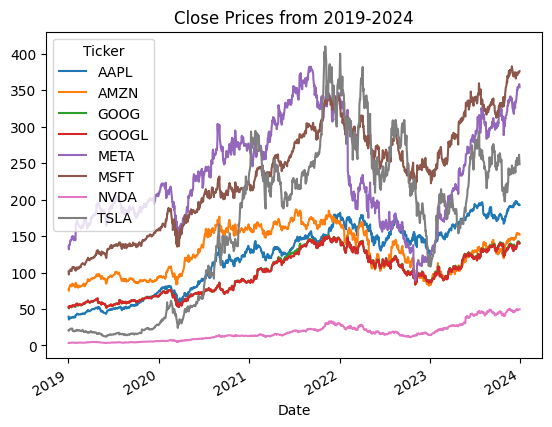

In [9]:
#plot close prices of 8 companies
close_prices.plot(title = "Close Prices from 2019-2024")
plt.show();plt.close()

**We have organized the close price data for 8 companies so that we can perform portfolio optimisation methods.**

**We will first find the portfolio that maximises the Sharpe Ratio, then minimises volatility**

In [10]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(close_prices)
Sigma = risk_models.sample_cov(close_prices)

#Calculate Efficient Frontier
ef = EfficientFrontier(mu, Sigma)

#Calculate weights
sharpe_raw_weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
print(dict(clean_weights))

ef.portfolio_performance(verbose=True)


{'AAPL': 0.27595, 'AMZN': 0.0, 'GOOG': 0.0, 'GOOGL': 0.0, 'META': 0.0, 'MSFT': 0.0, 'NVDA': 0.56653, 'TSLA': 0.15752}
Expected annual return: 60.7%
Annual volatility: 42.1%
Sharpe Ratio: 1.39


(0.6073879758270546, 0.4212902219529598, 1.3942596937192644)

In [11]:
#Optimize with min volatility
mu = expected_returns.mean_historical_return(close_prices)
Sigma = risk_models.sample_cov(close_prices)

#Calculate Efficient Frontier
ef = EfficientFrontier(mu, Sigma)

#Calculate weights
min_raw_weights = ef.min_volatility()
clean_weights = ef.clean_weights()
print(dict(clean_weights))

ef.portfolio_performance(verbose=True)



{'AAPL': 0.2583, 'AMZN': 0.14172, 'GOOG': 0.26255, 'GOOGL': 0.01418, 'META': 0.0, 'MSFT': 0.32325, 'NVDA': 0.0, 'TSLA': 0.0}
Expected annual return: 27.5%
Annual volatility: 28.3%
Sharpe Ratio: 0.90


(0.27544213699997566, 0.2828907244180181, 0.9029710589680466)

**Portfolio Allocation**

Determining the number of shares according to results

In [12]:
#Post-processing weights
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [13]:
#Finding the number of share one must buy according to max sharpe optimisation with linear programming and greedy algorithm
latest_prices = get_latest_prices(close_prices)
da_sharpe = DiscreteAllocation(sharpe_raw_weights, latest_prices, total_portfolio_value=100000)

#with linear programming
allocation, leftover = da_sharpe.lp_portfolio()
print("For $100,000 portfolio:\n\tBUY the number of shares of", allocation, "\n\tLeftover:", "${:.2f}".format(leftover))

#with  greedy algorithm
allocation_greedy , leftover_greedy = da_sharpe.greedy_portfolio()
print("\nFor $100,000 portfolio:\n\tBUY the number of shares of", allocation_greedy, "\n\tLeftover:", "${:.2f}".format(leftover_greedy))

For $100,000 portfolio:
	BUY the number of shares of {'AAPL': 143, 'NVDA': 1144, 'TSLA': 63} 
	Leftover: $160.80

For $100,000 portfolio:
	BUY the number of shares of {'NVDA': 1144, 'AAPL': 143, 'TSLA': 63} 
	Leftover: $160.80


In [14]:
#For Min. Volatility
latest_prices = get_latest_prices(close_prices)
da_vol = DiscreteAllocation(min_raw_weights, latest_prices, total_portfolio_value=100000)

#with linear programming
allocation, leftover = da_vol.lp_portfolio()
print("For $100,000 portfolio:\n\tBUY the number of shares of", allocation, "\n\tLeftover:", "${:.2f}".format(leftover))

#with  greedy algorithm
allocation_greedy , leftover_greedy = da_vol.greedy_portfolio()
print("\nFor $100,000 portfolio:\n\tBUY the number of shares of", allocation_greedy, "\n\tLeftover:", "${:.2f}".format(leftover_greedy))

For $100,000 portfolio:
	BUY the number of shares of {'AAPL': 134, 'AMZN': 93, 'GOOG': 186, 'GOOGL': 10, 'MSFT': 86} 
	Leftover: $121.24

For $100,000 portfolio:
	BUY the number of shares of {'MSFT': 86, 'GOOG': 186, 'AAPL': 134, 'AMZN': 93, 'GOOGL': 10} 
	Leftover: $121.24
